# Fractional Order Filter Design



psi=1531312.0779176427
corner frequency wo=62.83185307179586 rad/s, |H(wo)|=-3.01029995663981


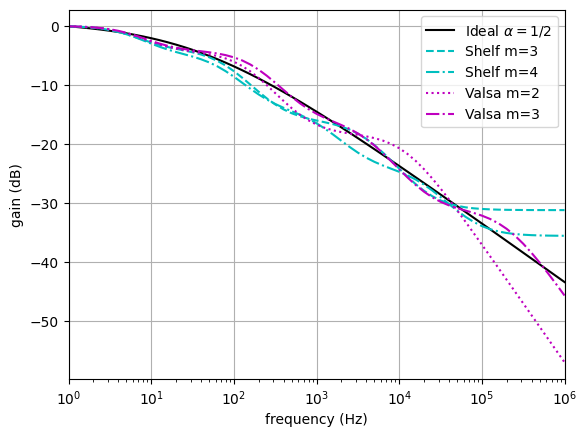

shelf3: 8.240670431000801
shelf4: 7.012772341675126
valsa2: 10.81075576732051
valsa3: 5.796851944168371


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

ww = 2*np.pi*np.logspace(0,6,51)

R = 100000
wo = 2*np.pi*10
# w0 = 100 -> 10 = 1/R\sqrt(Z) -> sqrt(Z) = 1/10R
# wcorner / woprime = acorner_sq
acorner_sq = 0.25*(np.sqrt(3) - 1)**2
psi = 2 * acorner_sq / wo / R**2  # = (R**2*psi)/2
print(f"psi={1.0 / np.sqrt(psi)}")

Hf = lambda w : 1 / (R * np.sqrt(w * psi) * (1 + 1j)/np.sqrt(2) + 1)

magH = np.abs(Hf(ww))

print(f"corner frequency wo={wo} rad/s, |H(wo)|={20*np.log10(np.abs(Hf(wo)))}")

ds = np.genfromtxt("assets/data/filter_response_compare.csv", delimiter=";", skip_header=True)

magH_dB = 20*np.log10(np.abs(Hf(ds[:,0]*2*np.pi)))

plt.semilogx(ds[:,0], magH_dB - magH_dB[0], 'k-', label=r"Ideal $\alpha=1/2$")
plt.semilogx(ds[:,0], ds[:,1] - ds[0,1], 'c--', label="Shelf m=3")
plt.semilogx(ds[:,0], ds[:,2] - ds[0,2], 'c-.', label="Shelf m=4")
plt.semilogx(ds[:,0], ds[:,3] - ds[0,3], 'm:', label="Valsa m=2")
plt.semilogx(ds[:,0], ds[:,4] - ds[0,4], 'm-.', label="Valsa m=3")
plt.grid(True)
plt.xlabel("frequency (Hz)")
plt.ylabel("gain (dB)")
plt.xlim([1, 1e6])
plt.legend(loc="upper right")
plt.show()

ind = ds[:,0] <= 1e5
errmag = lambda gain, gain_ref: np.linalg.norm(gain - gain_ref)
print(f"shelf3: {errmag(ds[ind,1], magH_dB[ind])}")
print(f"shelf4: {errmag(ds[ind,2], magH_dB[ind])}")
print(f"valsa2: {errmag(ds[ind,3], magH_dB[ind])}")
print(f"valsa3: {errmag(ds[ind,4], magH_dB[ind])}")



a=0.21319720680363816, b=0.21319720680363816, m=3.0
R=330.0k, C=10.0n
R=68.0k, C=2.2n
R=15.0k, C=0.47000000000000003n
R=1000.0k, C=0.1n
R_lpf = 150.0k


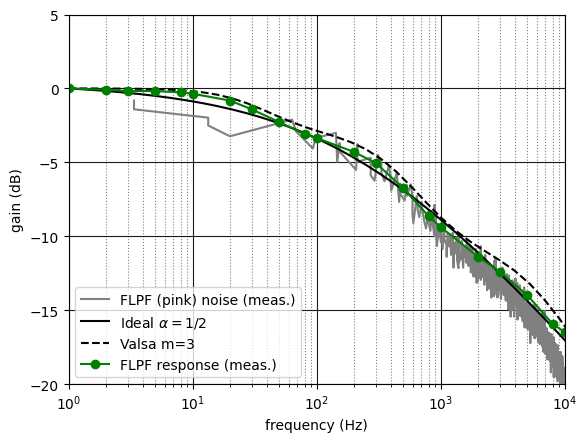

R_hpf = 22.0k


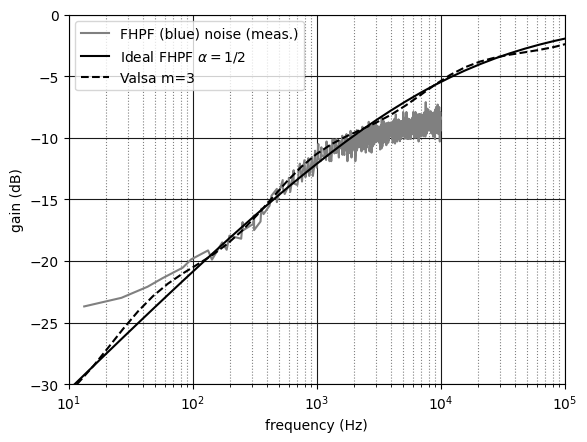

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

class FractionalCapValsa:
    allowed_C = [1.0, 2.2, 3.3, 4.7, 10.0]
    allowed_R = [1.0, 1.5, 2.2, 3.3, 4.7, 6.8, 10.0]

    def __init__(self, R1, fmin, fmax, m, alpha=0.5):
        
        self.R = [R1]
        self.wmin = 2*np.pi*fmin
        self.wmax = 2*np.pi*fmax
        self.m = m
        self.alpha = alpha
        
        phi_av = 90 * self.alpha
        
        #
        # find ab from m: m = 1 - log10(wmax/wmin) / log10(ab)
        #
        
        wratio = self.wmax / self.wmin
        log10_ab = np.log10(wratio)/(1 - self.m)
        ab = np.power(10.0, log10_ab)
        log10_a = self.alpha * log10_ab
        self.a = np.power(10., log10_a)
        self.b = ab/self.a
        self.m = np.round(self.m)

        self.C = [self._to_allowed_C(1./self.R[0]/self.wmin)]
        for k in range(1,int(self.m)):
            self.R.append(self._to_allowed_R(self.R[0] * self.a**k))
            self.C.append(self._to_allowed_C(self.C[0] * self.b**k))
        self.R.append(self._to_allowed_R(self.R[0] * (1.0 - self.a)/self.a))
        self.C.append(self._to_allowed_C(self.C[0] * self.b**self.m/(1-self.b)))

    def Yw(self, w):
        # admittance of a branch is jwC/(jwRC + 1)
        Yw = 1/self.R[-1] + 1j*w*self.C[-1]
        for k in range(len(self.R)-1):
            Yw += 1j*w*self.C[k] / (1j*w*self.R[k]*self.C[k] + 1)
        return Yw

    def psi(self, w=None):
        wav = np.sqrt(self.wmin * self.wmax) if w is None else w
        Yav = self.Yw(wav)
        return np.power(wav, self.alpha)/Yav

    def Rlpf(self):
        psi_wmin = np.abs(self.psi(w=self.wmin))
        psip = 1.0 / psi_wmin**2.0
        acorner_sq = 0.25*(np.sqrt(3) - 1)**2
        return self._to_allowed_R(np.sqrt(2.0* acorner_sq/valsa3.wmin/psip))
    
    def Rhpf(self):
        psi_wmin = np.abs(self.psi(w=self.wmin))
        acoeff = (1. / (np.sqrt(3) - 1.) )**2
        return self._to_allowed_R(np.sqrt(2 * psi_wmin**2 * acoeff / self.wmin))

    def _base10_exp(self, a):
        n = 0
        if a < 1.:
            while a < 1.0:
                n -= 1
                a *= 10.0
        else:
            while a > 10.:
                n += 1
                a /= 10.0
        assert(a >= 1.0 and a < 10.0)
        return a, n
                

    def _to_allowed_C(self, Cx):
        ma, ex = self._base10_exp(Cx)
        dd = [abs(v-ma) for v in self.allowed_C]
        return self.allowed_C[dd.index(min(dd))] * math.pow(10., ex)

    def _to_allowed_R(self, Rx):
        ma, ex = self._base10_exp(Rx)
        dd = [abs(v-ma) for v in self.allowed_R]
        return self.allowed_R[dd.index(min(dd))] * math.pow(10., ex)


def Hhpf_0p5_ideal(ff, fo, R):
    # Z = \psi/\sqrt(j\omega) = \psi (1 - j) / \sqrt(2\omega)
    ww = 2*np.pi*ff
    wo = 2*np.pi*fo
    psi = np.sqrt(0.5 * wo * R**2) * (np.sqrt(3) - 1.)
    Z = psi * (1 - 1j) / np.sqrt(2.* ww)
    return 1 / (Z/R + 1)

def Hlpf_0p5_ideal(ff, fo, R):
    wo = 2*np.pi*fo
    # w0 = 100 -> 10 = 1/R\sqrt(Z) -> sqrt(Z) = 1/10R
    # wcorner / woprime = acorner_sq
    acorner_sq = 0.25*(np.sqrt(3) - 1)**2
    psi = 2 * acorner_sq / wo / R**2  # = (R**2*psi)/2
    
    ww = 2*np.pi*ff
    return 1 / (R * np.sqrt(ww * psi) * (1 + 1j)/np.sqrt(2) + 1)

ww = 2*np.pi*np.logspace(0,6,51)
ff = ww/2/np.pi

f0 = 60
valsa3 = FractionalCapValsa(330e3, f0, 100000, 3.4)
#valsa3 = FractionalCapValsa(10e3, 100/(2*np.pi), 100000/(2*np.pi), 4.77, 2/3)
print(f"a={valsa3.a}, b={valsa3.b}, m={valsa3.m}")
for r, c in zip(valsa3.R, valsa3.C):
    print(f"R={r/1000.}k, C={c*1e9}n")

print(f"R_lpf = {valsa3.Rlpf()/1000.}k")

Rv = valsa3.Rlpf()
Zv = 1./valsa3.Yw(ww)
Hv = Zv/(Rv + Zv)

scope_data = np.genfromtxt("./assets/data/PN_spectrum_10kHz_from_scope.csv", skip_header=False, delimiter=",")
plt.semilogx(scope_data[:,0], scope_data[:,1] + 11, color="0.5", label=r"FLPF (pink) noise (meas.)")

# scope_data_1kHz = np.genfromtxt("./assets/data/PN_spectrum_from_scope.csv", skip_header=False, delimiter=",")
# plt.semilogx(scope_data_1kHz[:,0], scope_data_1kHz[:,1] + 26, color="0.4", label=r"FLPF (pink) noise (meas. 1kHz)")

magHv_dB = 20. * np.log10(np.abs(Hv))
magHa_dB = 20. * np.log10(np.abs(Hlpf_0p5_ideal(ff, f0, Rv)))
#plt.semilogx(ww/2/np.pi, magHi_dB - magHi_dB[0], 'k-', label=r"Ideal $\alpha=1/2$")
plt.semilogx(ff, magHa_dB - magHa_dB[0], 'k-', label=r"Ideal $\alpha=1/2$")
plt.semilogx(ff, magHv_dB - magHv_dB[0], 'k--', label=f"Valsa m={int(valsa3.m)}")

lpf_meas = np.genfromtxt("./assets/data/FLPF_meas.csv", delimiter=",", skip_header=True)
plt.semilogx(lpf_meas[:,0], 20*np.log10(lpf_meas[:,1]), 'g-o', label=f"FLPF response (meas.)")

plt.grid(visible=True, which="major", color="0.1", linestyle="-")
plt.grid(visible=True, which="minor", color="0.5", linestyle=":")
plt.xlabel("frequency (Hz)")
plt.ylabel("gain (dB)")
plt.xlim([1, 1e4])
plt.ylim([-20, 5])
plt.legend(loc="lower left")

plt.savefig("./assets/images/PN_filter_response.png", dpi=600)

plt.show()

#
# High pass
#
Rvh = 22e3
print(f"R_hpf = {Rvh/1000.}k")

Hvh = Rvh/(Rvh + Zv)

bn_scope_data = np.genfromtxt("./assets/data/BN_spectrum_10kHz_from_scope.csv", skip_header=False, delimiter=",")
plt.semilogx(bn_scope_data[:,0], bn_scope_data[:,1] + 26, color="0.5", label=r"FHPF (blue) noise (meas.)")

magHah_dB = 20. * np.log10(np.abs(Hhpf_0p5_ideal(ff, 40e3, Rvh)))
plt.semilogx(ff, magHah_dB, 'k-', label=r"Ideal FHPF $\alpha=1/2$")

magHvh_dB = 20. * np.log10(np.abs(Hvh))
plt.semilogx(ff, magHvh_dB, 'k--', label=f"Valsa m=3")

plt.grid(visible=True, which="major", color="0.1", linestyle="-")
plt.grid(visible=True, which="minor", color="0.5", linestyle=":")
plt.xlabel("frequency (Hz)")
plt.ylabel("gain (dB)")
plt.xlim([10, 1e5])
plt.ylim([-30,0])
plt.legend(loc="upper left")

plt.savefig("./assets/images/BN_filter_response.png", dpi=600)

plt.show()

